attempt 1

In [1]:
from openmmtools.testsystems import HostGuestExplicit

In [2]:
hge = HostGuestExplicit()

In [3]:
system, positions, topology = hge.system, hge.positions, hge.topology


In [4]:
from qmlify.openmm_torch.force_hybridization import HybridSystemFactory
from simtk import unit

In [5]:
from openmmtools.testsystems import HostGuestExplicit
T = 300*unit.kelvin
system, positions, topology = hge.system, hge.positions, hge.topology
system.removeForce(system.getNumForces() - 1) # remove the CMMotionRemover force because it is unknown
_atoms = list(range(126,156)) #these atoms correspond to the guest. query these with the second residue in the topology

In [6]:
system.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7fe3401fd840> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7fe2630c1900> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7fe2630c1ea0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7fe2630c1210> >]

In [7]:
hsf = HybridSystemFactory(topology = topology,
         alchemical_residue_indices = [1],
         system = system,
         softcore_alpha_sterics = 0.5,
         softcore_alpha_electrostatics = 0.5)
# grab the modified system and endstate system...
mod_system = hsf.system
endstate_system = hsf.endstate_system

INFO:force-hybridization:initializing system modifier...
INFO:force-hybridization:found 1 from [1]
INFO:force-hybridization:identified 30 to treat with ML.
INFO:force-hybridization:modifying harmonic bonds...
INFO:force-hybridization:modifying harmonic angles...
INFO:force-hybridization:modifying periodic torsions...
INFO:force-hybridization:modifying nonbondeds...
DEBUG:force-hybridization:iterating over existing exceptions and adding to custom force...
DEBUG:force-hybridization:iterating over alchemical particle combinations
DEBUG:force-hybridization:enabling rest-like scaling to alchemical particle nonbondeds


now that we have the modified system, we want to get the energy at _this_ endstate and make sure the energy is bookkeeping well with the non-alchemically-modified state.

In [8]:
from openmmtools.integrators import LangevinIntegrator
from simtk import openmm

In [9]:
nonalch_int = LangevinIntegrator(temperature=T)
alch_int = LangevinIntegrator(temperature=T)

In [10]:
nonalch_context, alch_context = openmm.Context(system, nonalch_int), openmm.Context(mod_system, alch_int)

In [11]:
for context in [nonalch_context, alch_context]:
    context.setPositions(positions)
    context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())

In [12]:
nonalch_context.getState(getEnergy=True).getPotentialEnergy()

Quantity(value=-51940.52312226919, unit=kilojoule/mole)

In [13]:
alch_context.getState(getEnergy=True).getPotentialEnergy()

Quantity(value=-51940.523090678435, unit=kilojoule/mole)

we're only off by a thousandth of a kj/mol.

if this is an artifact of the nonbonded term, we can safely ignore it.

In [14]:
from qmlify.openmm_torch.utils import *

In [15]:
from openmmtools.constants import kB

In [16]:
beta = 1. / (T * kB)

In [17]:
from openmmtools import utils

In [18]:
platform = utils.get_fastest_platform()

In [19]:
compute_potential_components(nonalch_context, beta, platform)

conducting subsequent work with the following platform: CPU


[('HarmonicBondForce', 139.49451696522257),
 ('HarmonicAngleForce', 255.44177887656315),
 ('PeriodicTorsionForce', 157.44462259341995),
 ('NonbondedForce', -21375.74437865682)]

In [20]:
compute_potential_components(alch_context, beta, platform)

conducting subsequent work with the following platform: CPU


[('HarmonicBondForce', 138.25363257328587),
 ('HarmonicAngleForce', 250.5430402178495),
 ('PeriodicTorsionForce', 127.8038989999598),
 ('NonbondedForce', -21397.72292678986),
 ('CustomBondForce', 1.2408843919367571),
 ('CustomAngleForce', 4.898738658713599),
 ('CustomTorsionForce', 29.64072359346019),
 ('CustomBondForce', 21.978560798018687)]

In [21]:
138.25363257328587 + 1.2408843919367571 - 139.49451696522257

5.684341886080802e-14

In [22]:
250.5430402178495 + 4.898738658713599 - 255.44177887656315

-5.684341886080802e-14

In [23]:
29.64072359346019 + 127.8038989999598 - 157.44462259341995

2.842170943040401e-14

so it is nonbonded. can we write a function that pushed the alchemical context to the opposite endstate and asserts that all of the custom forces go to zero?

first, let's gather the alchemical lambdas that must change...

In [24]:
final_lambdas = {'lambda_MM_bonds' : 0.,
                 'lambda_MM_angles': 0.,
                 'lambda_MM_torsions': 0.,
                 'lambda_nonbonded_MM_sterics' : 1.,
                 'lambda_nonbonded_MM_electrostatics': 1.,
                 }

In [25]:
for key, val in final_lambdas.items():
    alch_context.setParameter(key, val)

In [26]:
compute_potential_components(alch_context, beta, platform)

conducting subsequent work with the following platform: CPU


[('HarmonicBondForce', 138.25363257328587),
 ('HarmonicAngleForce', 250.5430402178495),
 ('PeriodicTorsionForce', 127.8038989999598),
 ('NonbondedForce', -21397.72292678986),
 ('CustomBondForce', 0.0),
 ('CustomAngleForce', 0.0),
 ('CustomTorsionForce', 0.0),
 ('CustomBondForce', 0.0)]

In [27]:
swig_params = alch_context.getParameters()

In [28]:
for i in swig_params:
    print(i, swig_params[i])
    

lambda_MM_angles 0.0
lambda_MM_bonds 0.0
lambda_MM_torsions 0.0
lambda_electrostatic_scale 0.0
lambda_epsilon_scale 0.0
lambda_nonbonded_MM_electrostatics 1.0
lambda_nonbonded_MM_sterics 1.0
lambda_scale 1.0


alright! now can we add the torchforce?

In [29]:
from qmlify.openmm_torch.torchforce_generator import torch_alchemification_wrapper

In [30]:
ml_system, hsf_mod = torch_alchemification_wrapper(topology, system, [1])

INFO:force-hybridization:initializing system modifier...
INFO:force-hybridization:found 1 from [1]
INFO:force-hybridization:identified 30 to treat with ML.
INFO:force-hybridization:modifying harmonic bonds...
INFO:force-hybridization:modifying harmonic angles...
INFO:force-hybridization:modifying periodic torsions...
INFO:force-hybridization:modifying nonbondeds...
DEBUG:force-hybridization:iterating over existing exceptions and adding to custom force...
DEBUG:force-hybridization:iterating over alchemical particle combinations
DEBUG:force-hybridization:enabling rest-like scaling to alchemical particle nonbondeds
INFO:torchforce_generator:registering `torch` device...
INFO:torchforce_generator:found torch device 'cuda': False
DEBUG:torchforce_generator:elements: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
DEBUG:torchforce_generator:species: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,

In [31]:
ml_system.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7f80fac30a20> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7f80ad3dac60> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7f80ad3da510> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f80ad71a270> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x7f80ad71ab40> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x7f80b4227ea0> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x7f80b42272d0> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x7f80ad4306c0> >,
 <simtk.openmm.openmm.

In [32]:
ml_int = LangevinIntegrator(splitting = 'V0 V1 R O R V1 V0')

In [33]:
ml_context = openmm.Context(ml_system, ml_int)

In [34]:
ml_context.setPositions(positions)

In [35]:
ml_context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())

In [36]:
import tqdm

In [37]:
swig_params = ml_context.getParameters()

In [38]:
ml_context.getState(getEnergy=True, groups={0}).getPotentialEnergy()

Quantity(value=-51940.523090678435, unit=kilojoule/mole)

In [39]:
ml_context.getState(getEnergy=True, groups={1}).getPotentialEnergy()

Quantity(value=0.0, unit=kilojoule/mole)

In [40]:
for i in swig_params:
    print(i, swig_params[i])

auxiliary_torch_scale 1.0
lambda_MM_angles 1.0
lambda_MM_bonds 1.0
lambda_MM_torsions 1.0
lambda_electrostatic_scale 0.0
lambda_epsilon_scale 0.0
lambda_nonbonded_MM_electrostatics 0.0
lambda_nonbonded_MM_sterics 0.0
lambda_scale 1.0
torch_scale 0.0


In [42]:
ml_energies, energies = [], []
for i in tqdm.trange(100):
    ml_int.step(1)
    alch_int.step(1)
    ml_energies.append(ml_context.getState(getEnergy=True).getPotentialEnergy())
    energies.append(alch_context.getState(getEnergy=True).getPotentialEnergy())

100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


In [43]:
import matplotlib.pyplot as plt

DEBUG:matplotlib:matplotlib data path: /home/dominic/anaconda3/envs/perses-torch/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/dominic/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.4.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collectio

DEBUG:matplotlib:CACHEDIR=/home/dominic/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/dominic/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [46]:
ml_energies = [energy.value_in_unit_system(unit.md_unit_system) for energy in ml_energies]
energies = [energy.value_in_unit_system(unit.md_unit_system) for energy in energies]

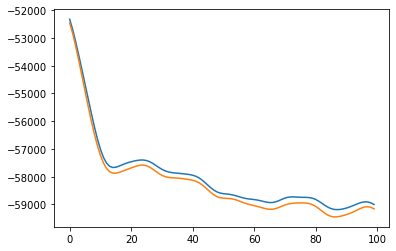

In [48]:
plt.plot(ml_energies)
plt.plot(energies)